## Contest [Link](https://hack.univ.ai/)

In [1]:
import os

BASE_DIR = '/content/drive/MyDrive/Hackerearth/univ_ai'
os.chdir(BASE_DIR)

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Define Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms, utils

In [4]:
RANDOM_SEED = 22
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# dimention of each data point in input
n_feats = 11

class Classifier(nn.Module):
    def __init__(self, inp_dim=n_feats):
        super(Classifier, self).__init__()
        self.inp_dim = inp_dim
        self.l1 = nn.Linear(inp_dim, 10)
        self.bn1 = nn.BatchNorm1d(10)
        self.l2 = nn.Linear(10, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.l3 = nn.Linear(5, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.l1(x)))
        x = F.relu(self.bn2(self.l2(x)))
        x = self.l3(x)

        return x

motivation for chossing criterian for this problem [1](https://stats.stackexchange.com/questions/485551/1-neuron-bce-loss-vs-2-neurons-ce-loss),  &nbsp; BCE vs CrossEntropy

In [6]:
model = Classifier().to(device)

optimizer = Adam(model.parameters())
criterian = nn.CrossEntropyLoss()

#### Create DataLoader and Dataset

In [7]:
class OurDataset(Dataset):
    def __init__(self, df):
        super(Dataset, self).__init__()
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # return self.df.iloc[idx].to_list()
        feats = self.df[['income', 'age', 'experience', 'married', 'house_ownership',
                         'car_ownership', 'profession', 'city', 'state', 'current_job_years', 'current_house_years']].iloc[idx].to_list()
        label = -1 if 'risk_flag' not in self.df.columns else self.df[['risk_flag']].iloc[idx].item()
        id = -1 if 'id' not in self.df.columns else self.df[['id']].iloc[idx].item()
        return {'feats': torch.tensor(feats), 'label': label, 'id': id}

#### Load the data

In [8]:
import pandas as pd
import numpy as np

In [9]:
b_size = 486

In [20]:
train_df = pd.read_csv(BASE_DIR + '/processed_data/train.csv') #.head(7000) 
train_df = train_df.groupby('risk_flag', group_keys=False).apply(lambda x: x.sample(min(len(x), 24000)))

train_dataset = OurDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=b_size*10, shuffle=True)

In [21]:
train_df.groupby('risk_flag').count()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
risk_flag,,,,,,,,,,,
0,24000,24000,24000,24000,24000,24000,24000,24000,24000,24000,24000
1,21763,21763,21763,21763,21763,21763,21763,21763,21763,21763,21763


In [ ]:
for x in [train_dataset, train_dataloader]:
    y = next(iter(x))
    print(type(y['label']))

<class 'int'>
<class 'torch.Tensor'>


In [10]:
val_df = pd.read_csv(BASE_DIR + '/processed_data/val.csv').head(7000)

val_dataset = OurDataset(val_df)
val_dataloader = DataLoader(val_dataset, batch_size=b_size, shuffle=True)

In [22]:
len(train_dataloader.dataset), len(train_dataloader) * b_size, len(train_dataset)

(45763, 4860, 45763)

#### Training Loop

In [11]:
from tqdm.autonotebook import tqdm

def train(n_epoch, train_dataloader, val_dataloader, model, criterian, optimizer):
    _benchmark = [{
        'train': [], 'val': []
    }, {
        'train': [], 'val': []
    }]
    for epoch in range(n_epoch):
        print('='*20, f' [Epoch {epoch+1}] ', '='*20)
        for phase, loader in [('train', train_dataloader), ('val', val_dataloader)]:
            running_loss, running_acc = 0.0, 0.0
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for batch in tqdm(loader, leave=False, position=0):
                optimizer.zero_grad()

                inputs, labels = batch['feats'], batch['label'].to(device)
                outs = model(inputs.to(device))
                loss = criterian(outs, labels.to(device))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.shape[0]
                running_acc += torch.sum(torch.argmax(outs, dim=1) == labels)

            running_loss /= len(loader.dataset)
            running_acc /= len(loader.dataset)
            _benchmark[0][phase].append(running_loss)
            _benchmark[1][phase].append(running_acc)

            print(f'{phase}: Loss {running_loss:.2f}, Acc: {running_acc:.2f}')

    return _benchmark


In [23]:
_losses, _accs = train(10, train_dataloader, val_dataloader, model, criterian, optimizer)
_benchmarks = [_losses, _accs]

====================  [Epoch 1]  ====================


train: Loss 1.04, Acc: 0.52


val: Loss 0.37, Acc: 0.88
====================  [Epoch 2]  ====================


train: Loss 1.00, Acc: 0.52


val: Loss 0.37, Acc: 0.88
====================  [Epoch 3]  ====================


train: Loss 0.97, Acc: 0.52


val: Loss 0.38, Acc: 0.88
====================  [Epoch 4]  ====================


train: Loss 0.94, Acc: 0.52


val: Loss 0.38, Acc: 0.88
====================  [Epoch 5]  ====================


train: Loss 0.91, Acc: 0.52


val: Loss 0.39, Acc: 0.88
====================  [Epoch 6]  ====================


train: Loss 0.88, Acc: 0.52


val: Loss 0.40, Acc: 0.88
====================  [Epoch 7]  ====================


train: Loss 0.86, Acc: 0.52


val: Loss 0.40, Acc: 0.88
====================  [Epoch 8]  ====================


train: Loss 0.84, Acc: 0.52


val: Loss 0.41, Acc: 0.88
====================  [Epoch 9]  ====================


train: Loss 0.82, Acc: 0.53


val: Loss 0.42, Acc: 0.88
====================  [Epoch 10]  ====================


train: Loss 0.80, Acc: 0.53


val: Loss 0.43, Acc: 0.87


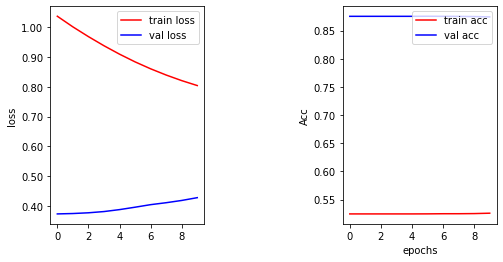

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), gridspec_kw={'hspace': 0.2, 'wspace': 0.9})

axes[0].plot(_losses['train'], color='red', label='train loss')
axes[0].plot(_losses['val'], color='blue', label='val loss')
axes[0].legend(loc="upper right")
axes[0].set_ylabel('loss')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axes[1].plot(_accs['train'], color='red', label='train acc')
axes[1].plot(_accs['val'], color='blue', label='val acc')
axes[1].legend(loc="upper right")
axes[1].set_ylabel('Acc')
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('epochs')
plt.show()

saving and loading models [1](https://pytorch.org/tutorials/beginner/saving_loading_models.html#id1)

In [ ]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'benchmarks': _benchmarks,
#     'n_epochs': 3,
#     'details': 'Trained on full dataset.'
# }, BASE_DIR + '/checkpoints/Apr4.h5')

In [12]:
! ls checkpoints

Apr2.h5  Apr3.h5


Loading checkpoints

In [13]:
checkpoint = torch.load(BASE_DIR + '/checkpoints/Apr3.h5')

In [14]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluate on test split

In [15]:
test_df = pd.read_csv(BASE_DIR + '/processed_data/val.csv')

test_dataset = OurDataset(test_df)
test_dataloader = DataLoader(test_dataset, b_size * 3, shuffle=True)

In [26]:
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

running_loss, running_acc = 0.0, 0.0
model.eval()

_labels, _preds = [], []

for batch in tqdm(test_dataloader, leave=False, position=0):
    inputs, labels = batch['feats'], batch['label'].to(device)

    outs = model(inputs.to(device))
    loss = criterian(outs, labels.to(device))

    running_loss += loss.item() * inputs.shape[0]
    preds = torch.argmax(outs, dim=1)
    running_acc += torch.sum(preds == labels)

    _labels.extend(labels.tolist())
    _preds.extend(preds.tolist())

running_loss /= len(test_dataloader.dataset)
running_acc /= len(test_dataloader.dataset)

print(f'Acc: {running_acc:.2f}, Loss: {running_loss:.2f}, roc_auc_score: {roc_auc_score(y_score=_preds, y_true= _labels)}')

Acc: 0.88, Loss: 0.43, roc_auc_score: 0.5010574428829215


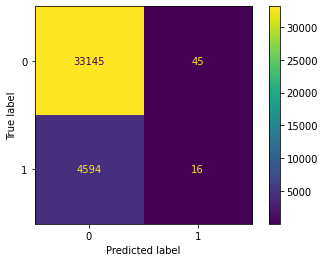

In [34]:
cm = confusion_matrix(_labels, _preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['0', '1'], )
cmd.plot(values_format='d')

### Prediction

In [ ]:
pred_df = pd.read_csv(BASE_DIR + '/processed_data/predict.csv')

pred_dataset = OurDataset(pred_df)
pred_dataloader = DataLoader(pred_dataset, b_size * 5)

In [ ]:
predictions = {
    'id': [], 'risk_flag': []
}

for batch in tqdm(pred_dataloader, leave=False, position=0):
    inputs, labels, ids = batch['feats'], batch['label'].to(device), batch['id'].tolist()

    outs = model(inputs.to(device))
    outs = torch.argmax(outs, dim=1).tolist()
    # print(labels, ids, outs, sep='\n', end='\n\n\n')
    # print(labels.shape, inputs.shape)
    # break
    predictions['id'].extend(ids)
    predictions['risk_flag'].extend(outs)


preds = pd.DataFrame(predictions)

In [ ]:
preds.head()

,id,risk_flag
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
preds.to_csv(BASE_DIR + '/processed_data/output.csv', index=False)

In [ ]:
preds.groupby('risk_flag').count()

,id
risk_flag,
0,19897
1,8103


#### Rough

In [ ]:
%cd processed_data/

/content/drive/MyDrive/Hackerearth/univ_ai/processed_data


In [ ]:
! wget https://lead-files.nyc3.cdn.digitaloceanspaces.com/data/hackathon-1/Sample%20Prediction%20Dataset.csv

--2021-04-02 18:44:46--  https://lead-files.nyc3.cdn.digitaloceanspaces.com/data/hackathon-1/Sample%20Prediction%20Dataset.csv
Resolving lead-files.nyc3.cdn.digitaloceanspaces.com (lead-files.nyc3.cdn.digitaloceanspaces.com)... 205.185.216.42, 205.185.216.10
Connecting to lead-files.nyc3.cdn.digitaloceanspaces.com (lead-files.nyc3.cdn.digitaloceanspaces.com)|205.185.216.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240908 (235K) [text/csv]
Saving to: ‘Sample Prediction Dataset.csv’

Sample Prediction D 100%[===================>] 235.26K  --.-KB/s    in 0.02s   

2021-04-02 18:44:48 (14.4 MB/s) - ‘Sample Prediction Dataset.csv’ saved [240908/240908]



In [ ]:
pd.read_csv('predict.csv').head()

,id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,0.739054,0.655172,0.95,0.0,0.0,0.0,0.507246,0.141566,0.8,0.285714,0.75
1,2,0.120596,0.068966,0.25,0.0,0.0,0.0,0.449275,0.355422,0.0,0.357143,0.00
2,3,0.890037,0.500000,0.60,0.0,0.0,0.0,0.434783,0.557229,0.0,0.642857,1.00
3,4,0.193614,0.482759,0.45,1.0,0.0,1.0,0.492754,0.927711,0.0,0.214286,0.50
4,5,0.000312,0.068966,0.90,0.0,0.0,1.0,0.231884,0.234940,0.8,0.928571,0.25
